<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/abr23_Regresion_covidCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wget
import wget
import pandas as pd
#datos covid19 - mundo
#url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
#wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


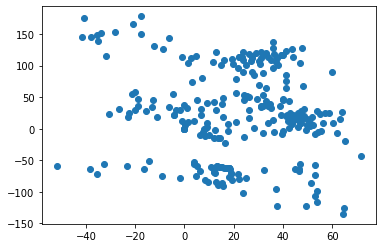

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(Xd['Lat'],Xd['Long'])

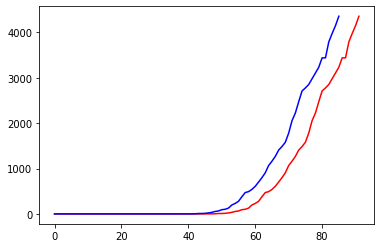

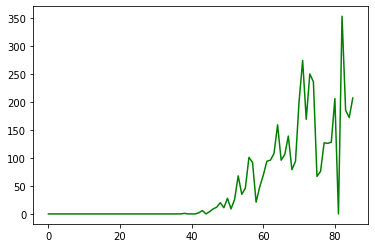

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N


ii = Xd[Xd.columns[1]] == 'Colombia'
#print(np.where(ii)[0][0])
#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))
X,y = covid_win(serie,w=5)
X_d,y_d = covid_win(serie_d,w=5)

plt.plot(serie,'r')
plt.plot(y,'b')
plt.show()
plt.plot(y_d,'g')



# Entrenamiento de regresor para covid 19 - Colombia
# Análisis exploratorio - visualización en 2D PCA
# Validación cruzada y anidada (pocos datos)

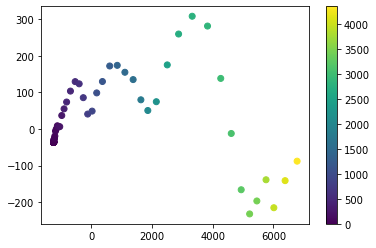

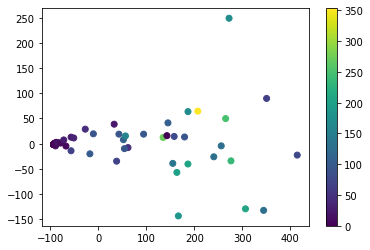

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#red = TSNE(n_components = 2,perplexity=10)
#red_d = TSNE(n_components = 2,perplexity=10)

red = PCA()
red_d = PCA()


z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()


plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()


In [16]:
red_d.explained_variance_ratio_

array([0.79948503, 0.0756895 , 0.06182384, 0.04139623, 0.02160539])

$$w^* = (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top y $$

$$y_n = \phi_n w^*$$


$\lambda$: hyperparameter

$\Phi(x)=\mathcal{N}(x|\mu,\sigma^2)$

$\mu,\sigma$ hyperparameters

$w$: model's parameter

In [6]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
#pocos datos y mucha incertidumbre, validación cruzada anidada

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(60, 5)
(26, 5)


In [0]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse

steps = [
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))], #clasificador 
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', KernelRidge(kernel = 'rbf'))], #clasificador 
         ]        


#parametros a buscar por busqueda por grilla
parameters =[
             {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
             },
             {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
              'rep__n_components':[0.5,0.75,0.9]
             },
              ]

label_model = ['NorSC-KRRBF','NorSC-PCA-KRRBF']


In [21]:
#valildacion cruzada anidada
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto
best_estimators = []#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = []#mejor metodo por iteracion 
#############################
          

for j in range(Niter): #outter loop
      print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) # xtrain 60, xtest 26
      for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_squared_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          #guardar mejor modelo
          best_estimators.append(grid_search.best_estimator_)
          best_hyperpar.append(grid_search.best_params_)
          
          #guardar acierto
          msev[j,r] = mse(y_test,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
          print(best_hyperpar)
          print('mse:',msev[j,r])
          
          savedata = {
              'acc':msev,
              'best_models':best_estimators,
              'best_parameters':best_hyperpar,
                } 
          dump(savedata,'covid19_1.joblib')

it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0426s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0867s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 126 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 142 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 153 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 164 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | ela

it 1/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 2022.8192868579233
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0503s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0683s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1364s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1761s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 477 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 490 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 503 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 518 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend wit

it 1/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 2294.0263369364943
it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0863s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0798s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 125 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0133s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0375s.)

it 2/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}]
mse: 1396.9870695748739
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0945s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1820s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0077s.) Setting batch_size=2

it 2/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 861.8001618284002
it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0466s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0840s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 144 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 155 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 3/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 1689.352579533966
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0739s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0826s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1590s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 366 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 439 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 452 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 496 tasks   

it 3/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 1307.1304970918509
it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1181s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0531s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed:    0.2s


it 4/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 2917.8430689869856
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0976s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0714s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1810s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 214 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 377 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 388 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 463 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 507 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 522 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 4/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 2292.7694193487387
it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0984s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1056s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 147 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 165 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 171 out of 180 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)

it 5/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 1253.0918870233656
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0517s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1049s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1954s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 366 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 377 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 496 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 511 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 526 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n

it 5/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 1416.6196524692493
it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0771s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0607s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 131 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 155 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 6/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 3427.0587244649673
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0621s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1120s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1464s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_

it 6/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 3030.418122870823
it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0540s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0784s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 127 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 165 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished


it 7/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 4102.153878417219
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0713s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1713s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Ba

it 7/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 3140.433944912317
it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0549s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0890s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1080s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computatio

it 8/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}]
mse: 3500.8903749161286
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0522s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0996s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1421s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 214 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 346 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 357 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 432 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 445 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 522 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computati

it 8/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 1421.763063082753
it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1445s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 171 out of 180 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0230s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0230s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


it 9/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 2423.722875060543
Fitting 5 folds for each of 108 cand

[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0709s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0831s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1270s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 324 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 366 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 408 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 421 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 496 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 511 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 526 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n

it 9/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components

[Parallel(n_jobs=5)]: Batch computation too fast (0.0782s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 119 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 142 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 153 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 164 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0074s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 10/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_component

[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0341s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0956s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0962s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 198 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 374 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 460 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 488 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 501 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 516 tasks      | elapsed:    1.7s


it 10/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.01, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.01, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_component

[Parallel(n_jobs=5)]: Done 531 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished


Por Niter de outter loop tengo valores de los hyperparameters

$$\gamma = [0.01,0.1,10,1000,10000,0.01]$$

$$\gamma = [0.01,0.01,0.01,0.1,1,0.01]$$

$$\gamma^* = moda/mediana(\gamma_i) = 0.01$$

Toma todos los datos los N = 85, entreno sobre todo el conjunto con los parametros encontrados utilizando validación cruzada anidad

$$\theta^*/w^* =f(X|\gamma^*)$$

$$ y_{new} = f(x_{new}|\gamma^*,\theta^*/w^*)$$

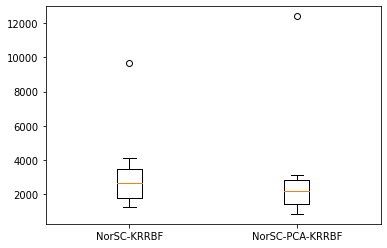

In [25]:
plt.boxplot(msev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()